In [2]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

from scipy.stats.mstats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from scipy.stats import sem

from nilearn.signal import clean

In [3]:
os.chdir('../')

In [4]:
# loa my modules
from src.PMA_SCCA import SCCA
from src.utils import load_pkl
from src.visualise import *
from src.file_io import save_output

In [5]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

In [6]:
FC_yeo7 = dataset['FC_Yeo7']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [7]:
def parameter_grid(para, para_fn):
    i = np.argmin(paramat)
    d_idx = np.unravel_index(i, paramat.shape)
    
    title = 'Sparsity Parameter Search'
    hm = plt.matshow(paramat.T, vmin=0, vmax=0.5)
    plt.xticks(range(9), np.array(range(1, 10)) * 0.1)
    plt.yticks(range(9), np.array(range(1, 10)) * 0.1)
    plt.xlabel('Connectivity')
    plt.ylabel('Cognitive Task')
    plt.title(title)
    plt.colorbar(hm, label='Canonical Correlation')
    # Create a Rectangle patch
    rect = patches.Rectangle(np.array(d_idx) - 0.5, 1, 1,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    hm.axes.add_patch(rect)
    hm.axes.xaxis.set_ticks_position('bottom')
#     for (i, j), z in np.ndenumerate(K_mat.T):
#         hm.axes.text(j, i, '{:0}'.format(z), ha='center', va='center')

    plt.show()
    #     plt.savefig(para_fn, dpi=300)
    plt.close()

    return d_idx

# Cleaning confounds

We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.

In [8]:
def clean_confound(RS, COG, confmat):

    # regress out confound
    z_confound = zscore(confmat)
    # squared measures to help account for potentially nonlinear effects of these confounds
    z2_confound = z_confound ** 2
    conf_mat = np.hstack((z_confound, z2_confound))

    # clean signal
    RS_clean = clean(np.arctanh(RS), confounds=conf_mat, detrend=False, standardize=False)
    COG_clean = clean(zscore(COG), confounds=conf_mat, detrend=False, standardize=False)

    return RS_clean, COG_clean, conf_mat

# K-Fold CV for parameters/model selection

## Penalty selection CV

Grid search range, set up inner and outer folds and the parameter grid

In [13]:
out_folds = 5
in_folds = 2
para_x, para_y = 9, 9
n_selected = 4
param_setting = {
    'reg_X': np.array(range(1, para_x + 1)) * 0.1,
    'reg_Y': np.array(range(1, para_y + 1)) * 0.1,}

In [14]:
KF_out = KFold(n_splits=out_folds, shuffle=True, random_state=42)
KF_in = KFold(n_splits=in_folds)
param_grid = ParameterGrid(param_setting)

==Train-test split 1/5==

Best parameters based on cross-validation:[ 0.9  0.4]

Best parameters based on cross-validation:[ 0.9  0.4]
Prediction error:0.121603

New Best model: 
 4 components,penalty x: 0.9, penalty y: 0.4
O-O-S test error: 0.121603



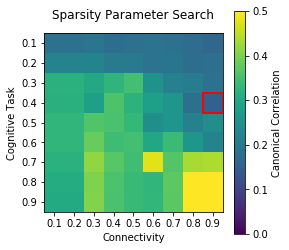

==Train-test split 2/5==

Best parameters based on cross-validation:[ 0.9  0.4]

Best parameters based on cross-validation:[ 0.9  0.4]
Prediction error:0.076370

New Best model: 
 4 components,penalty x: 0.9, penalty y: 0.4
O-O-S test error: 0.076370



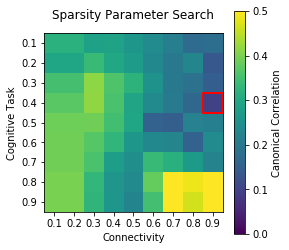

==Train-test split 3/5==

Best parameters based on cross-validation:[ 0.1  0.1]

Best parameters based on cross-validation:[ 0.1  0.1]
Prediction error:0.123347


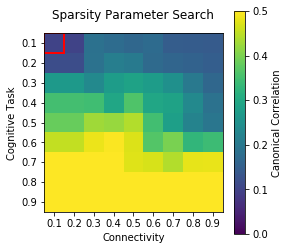

==Train-test split 4/5==

Best parameters based on cross-validation:[ 0.7  0.1]

Best parameters based on cross-validation:[ 0.7  0.1]
Prediction error:0.110589


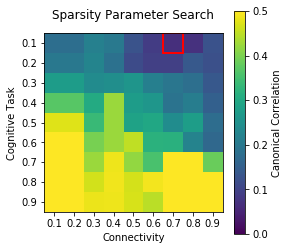

==Train-test split 5/5==

Best parameters based on cross-validation:[ 0.9  0.1]

Best parameters based on cross-validation:[ 0.9  0.1]
Prediction error:0.121177


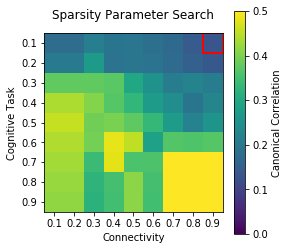

In [15]:
best_model = None
error_best = 0.5

for i, (train_idx, test_idx) in enumerate(KF_out.split(FC_yeo7)):
    print('==Train-test split {0:}/{1:}=='.format(i + 1, out_folds))
    X_discovery, X_test = FC_yeo7[train_idx], FC_yeo7[test_idx]
    Y_discovery, Y_test = MRIQ[train_idx], MRIQ[test_idx]
    conf_discovery, conf_test = confound_raw[train_idx], confound_raw[test_idx]

    i_best_model = None
    di_best = 1
    di_orig = 0 
    para_search = np.zeros((para_x, para_y))
    for j, parameters in enumerate(iter(param_grid)):
#         print('\nPenalty: x - {0:}, y - {1:}; component: {2:}'.format(
#                 parameters['reg_X'], parameters['reg_Y'], parameters['n_factor']))

        para_idx = np.unravel_index(j, para_search.shape) # (C_x,C_y, K)
        model = SCCA(n_components=n_selected, scale=False, n_iter=50,
                     penX=parameters['reg_X'], penY=parameters['reg_Y'],
                    )
        j_model = None
        dj_best = 1
        dj_orig = 0
        for k, (train_idx, test_idx) in enumerate(KF_in.split(X_discovery)):

            # find best weights for this hyper parameter set
            X_train, X_confirm = X_discovery[train_idx], X_discovery[test_idx]
            Y_train, Y_confirm = Y_discovery[train_idx], Y_discovery[test_idx]
            conf_train, conf_confirm = conf_discovery[train_idx], conf_discovery[test_idx]

            X_train_clean, Y_train_clean, confmat_train_clean = clean_confound(
                                        X_train, Y_train, conf_train)
            X_confirm_clean, Y_confirm_clean, conf_confirm_clean = clean_confound(
                            X_confirm, Y_confirm, conf_confirm)

            model.fit(X_train_clean, Y_train_clean)
            d_orig = np.mean(model.score(X_train_clean, Y_train_clean))
            d_k = np.mean(model.score(X_confirm_clean, Y_confirm_clean))
            error_k = np.abs(d_orig - d_k)

            if error_k < dj_best:
                dj_orig = d_orig
                dj_best = error_k
                j_model = copy.deepcopy(model)
                
        para_search[para_idx] = dj_best

        # check if the current parameter is the best in of the current outer fold
        if dj_best < di_best:
            di_orig = dj_orig
            di_best = dj_best
            i_best_model = copy.deepcopy(j_model)

    # plot the model search of current fold
    d_idx = np.argwhere(para_search == di_best)[0]
    C = 0.1 * (d_idx[:2] + 1)

    paramat = para_search
    para_fn = ' '
    # apply test set on the final model
    X_test_clean, Y_test_clean, conf_test_clean = clean_confound(X_test, Y_test, conf_test)
    di = np.mean(i_best_model.score(X_test_clean, Y_test_clean))
    pred_error = np.abs(di_orig - di)
    print('\nBest parameters based on cross-validation:{:}'.format(C))
    print('\nBest parameters based on cross-validation:{:}'.format(C))
    print('Prediction error:{:f}'.format(pred_error))
    
    if pred_error < error_best:
        error_best = pred_error
        best_model = copy.deepcopy(i_best_model)
        print('\nNew Best model: \n {:} components,penalty x: {:}, penalty y: {:}\nO-O-S test error: {:f}\n'.format(
                    best_model.n_components, best_model.penX, best_model.penY, error_best))
    parameter_grid(paramat, para_fn)

In [16]:
set_text_size(12)
u, v = best_model.u, best_model.v

figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)

write_pdf('./reports/revision/bestModel_confoundclean_collection_nested_{0:1d}_{1:.1f}_{2:.1f}_.pdf'.format(
                best_model.n_components, best_model.penX, best_model.penY), figs)

In [18]:
X, Y, _ = clean_confound(FC_yeo7, MRIQ, confound_raw)

X_scores, Y_scores, df_z = save_output(dataset, best_model, X, Y, path=None)

In [19]:
df_z.to_csv('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))